# Introduction
*Phipps et Bagenal (2021)* develop a model for the position of the centrifugal equator in the jovicentric frame. They provide a parametric equation which give the latitude of the centrifugal equator at any given distance to jupiter and longitude. However, their result is not directly applicable to my project. Indeed, I need to be able to compute the position of the centrifugal equator from knowledge on the longitude and the Mshell value. 

Based on Jonas Rabias script (*Rabia et al 2023*), it is possible to compute the Mshell corresponding to any given location on the magnetosphere. However, this derivation is time consuming and cannot be applied to inversion problems. In other words, going, with this method, from $r_{cent}, \phi_{cent} \rightarrow \lambda_{cent} \rightarrow Mshell$ to $Mshell, \phi_{cent} \rightarrow r \rightarrow \lambda_{cent}$ where $r$ is the jovicentric distance, $\lambda_{cent}$ is the jovicentric latitude and $\phi_{cent}$ is the longitude of the centrifugal equator point would be very unefficient and introduce important computational errors.

Building on *Phipps et Bagenal (2021)*, I intend to approximate the relation between the location of the centrifugal equator and its Mshell value with an analytical function, and to invert it to be able to compute the complete set of coordinates describing the location of the centrifugal equator, from knowledge on the longitude and the Mshell value only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import os

# Default plotting parameters
plt.rcParams.update({'font.size': 20})

# Global parameters
pi = np.pi
labelfontsize=12

In [2]:
def extractfilelines(filename: str, titlemarker="#"):
    # -----------------------------------------------
    # This function converts a text file (at location specified by filename)
    # into a list of its lines in text format
    # -----------------------------------------------
    with open(filename, "r") as f:
        # read title
        line = f.readline()
        while line.startswith(titlemarker):
            line = f.readline()

        lines = [line] + f.readlines()

    return lines

def fitandplot(axs, fitfunction, xarrays, yarrays, args0, labelin="",
               textloc_ind_offset=(0, 0.), transformfunction=None, colorin=None):
    
    res = curve_fit(fitfunction, xarrays, yarrays, p0=args0)
    argsopt = res[0]
    cov = res[1]
    ysmodel = fitfunction(xarrays, *argsopt)
    
    print("\n At "+labelin)
    print("Values = ", ["{:.2f}".format(arg) for arg in argsopt])
    print("Variance =", ["{:.2e}".format(cov[i, i]) for i in range(argsopt.size)])

    if colorin is None:
        p = axs[0].plot(xarrays, yarrays, alpha=0.5)
        colorin = p[0].get_color()
    else:
        axs[0].plot(xarrays, yarrays, alpha=0.5, color=colorin)
    axs[0].plot(xarrays, ysmodel, alpha=0.5, color=colorin,linestyle=":")
    axs[0].text(xarrays[textloc_ind_offset[0]], yarrays[textloc_ind_offset[0]]+textloc_ind_offset[1],
                labelin, color=colorin, fontsize=labelfontsize)
    
    kin = 1
    if not transformfunction is None:
        ysplot = transformfunction(yarrays)
        ysmodelplot = transformfunction(ysmodel)
        axs[kin].plot(xarrays, ysplot, alpha=0.5, color=colorin)
        axs[kin].plot(xarrays, ysmodelplot, alpha=0.5, color=colorin,linestyle=":")
        kin+=1
        
    axs[kin].plot(xarrays, 100.*np.abs(yarrays-ysmodel)/yarrays, color=colorin)
    return argsopt, cov

# Study the dependance between Mshell and the location of the centrifugal equator

## Computing Mshell values throughout the centrifugal equator

This important piece of work has been conducted beforehand. For a selected sample of the centrifugal equator in terms of jovicentric spherical radius $r_{cent}$ (100 values from 5$R_J$ to 30$R_J$) and SIII longitude $\phi_{cent}$ (60 values from 0° to 360°), the centrifugal equator latitude $\lambda_{cent}$ is derived using the parameteric equation of *Phipps et Bagenal (2021)*. From the complete coordinate description, the Mshell value of each point on the centrifugal equator is computed using Jonas Rabia script. This data is loaded on the present file from a text file.

From there, I am directly modifying the data to try and extract tendencies in terms of Mshell values, which would allow to write $Mshell = G_{r_{cent}}(\phi_{cent})$ and $Mshell = F_{\phi_{cent}}(r_{cent})$ for fixed $r_{cent}$ and $\phi_{cent}$ respectivelly. 
The first step is to load the data as numpy arrays.

In [3]:
# users parameters
model = 'JRM33+CON2020'  # magnetic field model used
npoints = 100, 60
radlims = ("5", "30")
savefiletitle = "centrifugalequator_radius{}min{}max{}pts_latitude_longitude{}pts_"\
                "mshell{}".format(radlims[0], radlims[1], npoints[1], npoints[0], model)

In [4]:
# defining and filling data tables from the text file
mshells ,radiis, longitudes,latitudes = np.zeros(npoints), np.zeros(npoints), np.zeros(npoints), np.zeros(npoints)
lines = extractfilelines(savefiletitle+".txt")
k = 0
for i in range(npoints[0]):
    for j in range(npoints[1]):
        line = lines[k]
        strvals = line.strip().split()

        radiis[i, j] = float(strvals[0].strip())
        latitudes[i, j] = float(strvals[1].strip())
        longitudes[i, j] = float(strvals[2].strip())
        mshells[i, j] = float(strvals[3].strip())
        k+=1

In [5]:
# testing data tables format
for k in range(0, npoints[0], npoints[0]//5):
    print("Values on line "+str(k))
    print("r in [{:.2f}, {:.2f}] RJ ; phi in [{:.2f}, {:.2f}] deg ; lambda in [{:.2f}, {:.2f}] deg ; "\
          "mshell in [{:.2f}, {:.2f}] RJ".format(np.min(radiis[k]), np.max(radiis[k]), np.min(longitudes[k]), 
                                                 np.max(longitudes[k]), np.min(latitudes[k]), np.max(latitudes[k]), 
                                                 np.min(mshells[k]), np.max(mshells[k])))
print("\n")
for k in range(0, npoints[1], npoints[1]//5):
    print("Values on column "+str(k))
    print("r in [{:.2f}, {:.2f}] RJ ; phi in [{:.2f}, {:.2f}] deg ; lambda in [{:.2f}, {:.2f}] deg ; "\
          "mshell in [{:.2f}, {:.2f}] RJ".format(np.min(radiis[:, k]), np.max(radiis[:, k]), np.min(longitudes[:, k]), 
                                                 np.max(longitudes[:, k]), np.min(latitudes[:, k]), np.max(latitudes[:, k]), 
                                                 np.min(mshells[:, k]), np.max(mshells[:, k])))

Values on line 0
r in [5.00, 30.00] RJ ; phi in [0.00, 0.00] deg ; lambda in [6.09, 8.76] deg ; mshell in [5.01, 30.00] RJ
Values on line 20
r in [5.00, 30.00] RJ ; phi in [72.73, 72.73] deg ; lambda in [4.04, 5.81] deg ; mshell in [5.01, 44.56] RJ
Values on line 40
r in [5.00, 30.00] RJ ; phi in [145.45, 145.45] deg ; lambda in [-5.31, -3.69] deg ; mshell in [5.05, 37.08] RJ
Values on line 60
r in [5.00, 30.00] RJ ; phi in [218.18, 218.18] deg ; lambda in [-8.97, -6.23] deg ; mshell in [5.00, 38.38] RJ
Values on line 80
r in [5.00, 30.00] RJ ; phi in [290.91, 290.91] deg ; lambda in [-0.01, -0.01] deg ; mshell in [5.11, 44.04] RJ


Values on column 0
r in [5.00, 5.00] RJ ; phi in [0.00, 360.00] deg ; lambda in [-6.52, 6.52] deg ; mshell in [5.00, 5.11] RJ
Values on column 12
r in [10.08, 10.08] RJ ; phi in [0.00, 360.00] deg ; lambda in [-7.28, 7.28] deg ; mshell in [10.08, 10.35] RJ
Values on column 24
r in [15.17, 15.17] RJ ; phi in [0.00, 360.00] deg ; lambda in [-8.34, 8.34] deg ;

## Tentative detection of analytical relations between Mshell and the longitude

I first intend to tweak the Mshell VS $\phi_{cent}$ data in order to extract potential tendances. A first subfigure simply shows the variation of Mshell with longitude, at various fixed radii. The second subfigure applies the transformation $$Mshell \rightarrow \frac{Mshell - mean(Mshell)}{min(Mshell) - max(Mshell)}.$$
This transformation aims at making sine dependances clearly visible : if Mshell is a sine function of $\phi_{cent}$, which amplitude, offset and delay depend on $r_{cent}$, then all curve should become centered, normalised sines with various delay values.

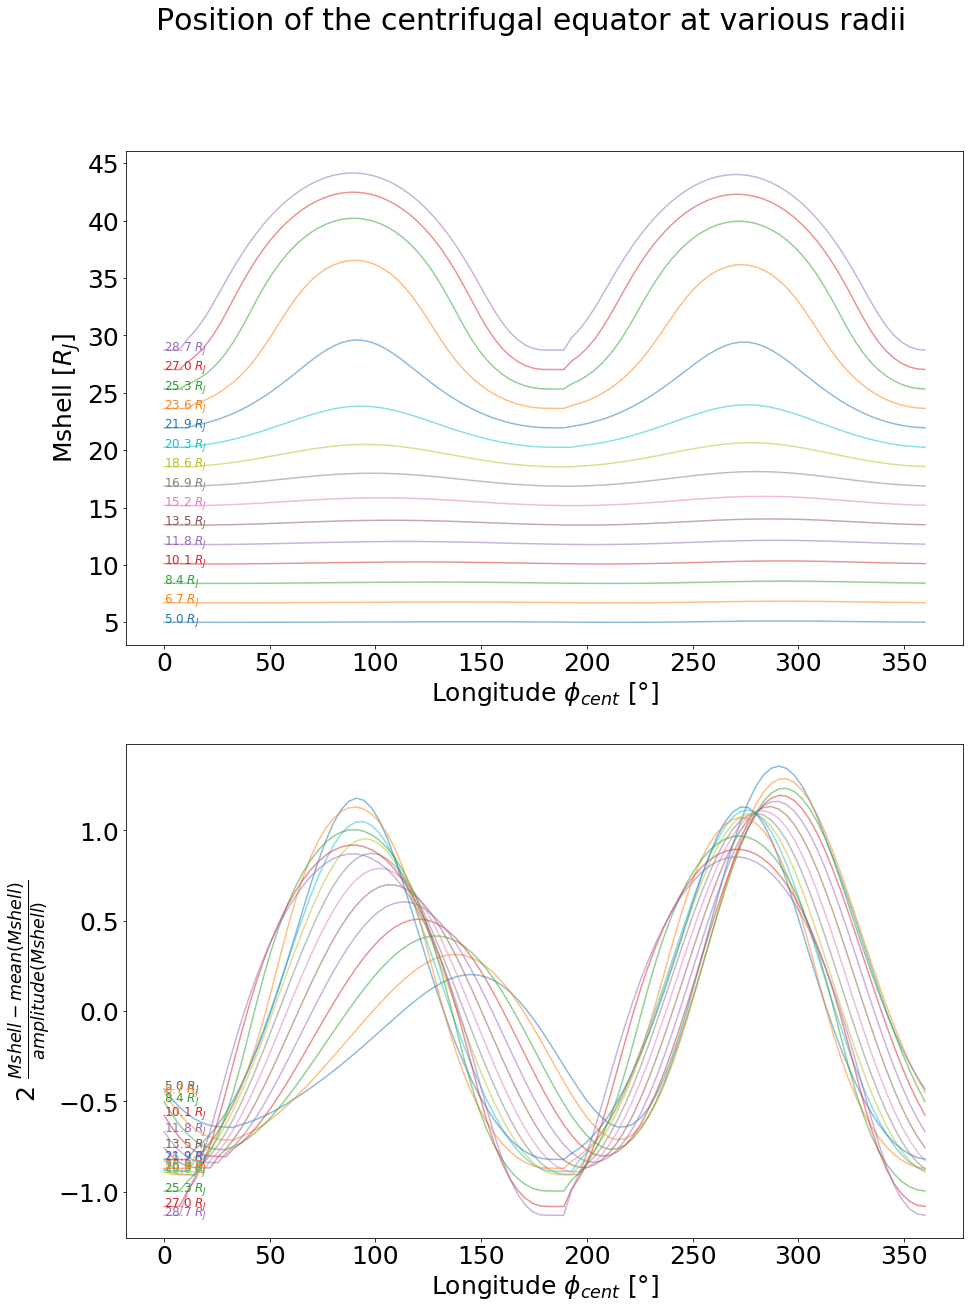

In [6]:
# Plot Mshell VS longitude
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(211)
axmodify = fig.add_subplot(212)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for k in range(0, npoints[1], npoints[1]//15):
    r = radiis[0, k]
    mss = mshells[:, k]
    mssplot = 2*(mss-np.mean(mss))/(np.max(mss)-np.min(mss))
    p = ax.plot(longitudes[:, k], mss, alpha=0.5)
    ax.text(longitudes[0, k], mss[0], "{:.1f} $R_J$".format(r), color=p[0].get_color(), fontsize=labelfontsize)
    axmodify.plot(longitudes[:, k], mssplot, alpha=0.5, color=p[0].get_color())
    axmodify.text(longitudes[0, k], mssplot[0], "{:.1f} $R_J$".format(r),color=p[0].get_color(), fontsize=labelfontsize)
    
plt.setp([ax, axmodify], xlabel="Longitude $\phi_{cent}$ [°]")
ax.set_ylabel("Mshell [$R_J$]")
axmodify.set_ylabel(r"2 $\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
fig.suptitle("Position of the centrifugal equator at various radii")
plt.show()

From the second figure, it appears that, even though the dependance of Mshell on $\phi_{cent}$ seems to become sinusoidal at high radii, that is not at all the case at lower radii (e.g. $r_{cent} = 5 R_J$). It could eventually be necessary to include an affine amplitude, which parameters would depend on r, as well as a variable delay with $\phi_{cent}$. This is what we explore in the following.

Fitting to data : delay, slope, amplitude offset, total offset

 At 5.0 $R_J$
Values =  ['18.65', '-0.00', '0.05', '5.01']
Variance = ['3.01e+01', '4.95e-09', '1.90e-04', '2.33e-05']

 At 7.5 $R_J$
Values =  ['26.97', '-0.00', '0.11', '7.57']
Variance = ['3.19e+01', '9.57e-09', '3.93e-04', '4.95e-05']

 At 10.1 $R_J$
Values =  ['23.21', '-0.00', '0.22', '10.13']
Variance = ['1.67e+01', '2.26e-08', '9.19e-04', '1.13e-04']

 At 12.6 $R_J$
Values =  ['16.61', '-0.00', '0.46', '12.68']
Variance = ['9.22e+00', '6.43e-08', '2.52e-03', '3.06e-04']

 At 15.2 $R_J$
Values =  ['10.72', '-0.01', '0.97', '15.23']
Variance = ['6.45e+00', '2.27e-07', '8.57e-03', '1.05e-03']

 At 17.7 $R_J$
Values =  ['6.35', '-0.01', '2.08', '17.80']
Variance = ['5.58e+00', '9.74e-07', '3.58e-02', '4.45e-03']

 At 20.3 $R_J$
Values =  ['3.54', '-0.03', '4.88', '20.38']
Variance = ['5.55e+00', '5.52e-06', '1.99e-01', '2.51e-02']

 At 22.8 $R_J$
Values =  ['2.21', '-0.08', '14.12', '22.83']
Variance = ['6.10e+00', '5.

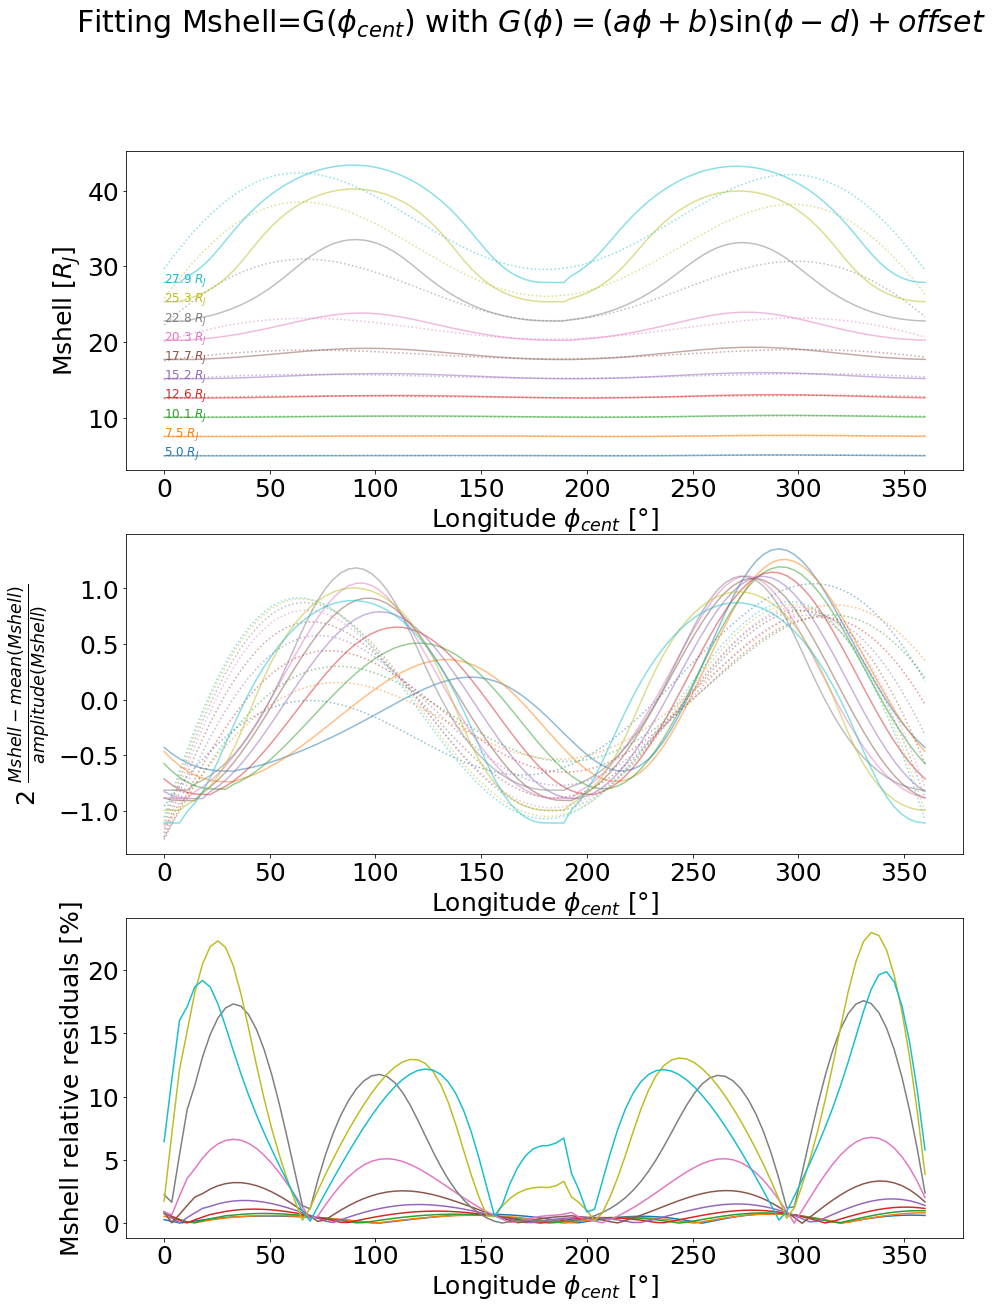

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel(r"2 $\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
axs[2].set_ylabel("Mshell relative residuals [%]")
fig.suptitle("Fitting Mshell=G($\phi_{cent}$) with $G(\phi)=(a\phi + b)\sin(\phi-d)+offset$")

def fitfunc_long(longitude, delay, slope, offsetamplitude, offset):
    return np.sin(pi/180.*(longitude-delay))*(slope*longitude+offsetamplitude) + offset

argsoptlists = []

print("Fitting to data : delay, slope, amplitude offset, total offset")
for k in range(0, npoints[1], npoints[1]//10):
    r = radiis[0, k]
    mss = mshells[:, k]
    lons = longitudes[:, k]
    argsopt, _ = fitandplot(axs, fitfunc_long, lons, mss, np.array([50., 0., 1., np.mean(mss)]),
                            labelin="{:.1f} $R_J$".format(r),textloc_ind_offset=(0, 0.),
                            transformfunction=lambda x:2.*(x-np.mean(x))/(np.max(x)-np.min(x)))
    argsoptlists.append(argsopt)
    
plt.show()

As seen in the previous panel, the suggested model does not properly fits the Mshell VS longitude relation. Especially, the locations of the peak values are not well reproduced by the simple affine modulated sine function. Hence I try to improve it by adding a additional variable frequency for the sine modulation in the next panels.

Fitting to data : delay, slope, amplitude offset, total offset, frequency

 At 5.0 $R_J$
Values =  ['113.31', '-0.00', '0.06', '5.03', '0.03']
Variance = ['4.11e+00', '3.53e-10', '1.45e-05', '1.70e-06', '8.23e-08']

 At 7.5 $R_J$
Values =  ['110.06', '-0.00', '0.09', '7.60', '0.03']
Variance = ['7.28e+00', '1.03e-09', '4.17e-05', '5.15e-06', '1.37e-07']

 At 10.1 $R_J$
Values =  ['102.95', '-0.00', '0.13', '10.19', '0.03']
Variance = ['1.74e+01', '3.61e-09', '1.43e-04', '2.02e-05', '2.88e-07']

 At 12.6 $R_J$
Values =  ['36.27', '-0.00', '0.44', '12.72', '0.02']
Variance = ['1.17e+01', '3.44e-08', '1.31e-03', '1.88e-04', '1.04e-07']

 At 15.2 $R_J$
Values =  ['29.26', '-0.01', '0.97', '15.32', '0.02']
Variance = ['6.03e+00', '1.01e-07', '3.75e-03', '5.33e-04', '5.78e-08']

 At 17.7 $R_J$
Values =  ['25.28', '-0.01', '2.11', '17.98', '0.02']
Variance = ['4.40e+00', '3.80e-07', '1.38e-02', '1.97e-03', '4.41e-08']

 At 20.3 $R_J$
Values =  ['22.85', '-0.03', '4.99', '20.79', '0.02']
Varia

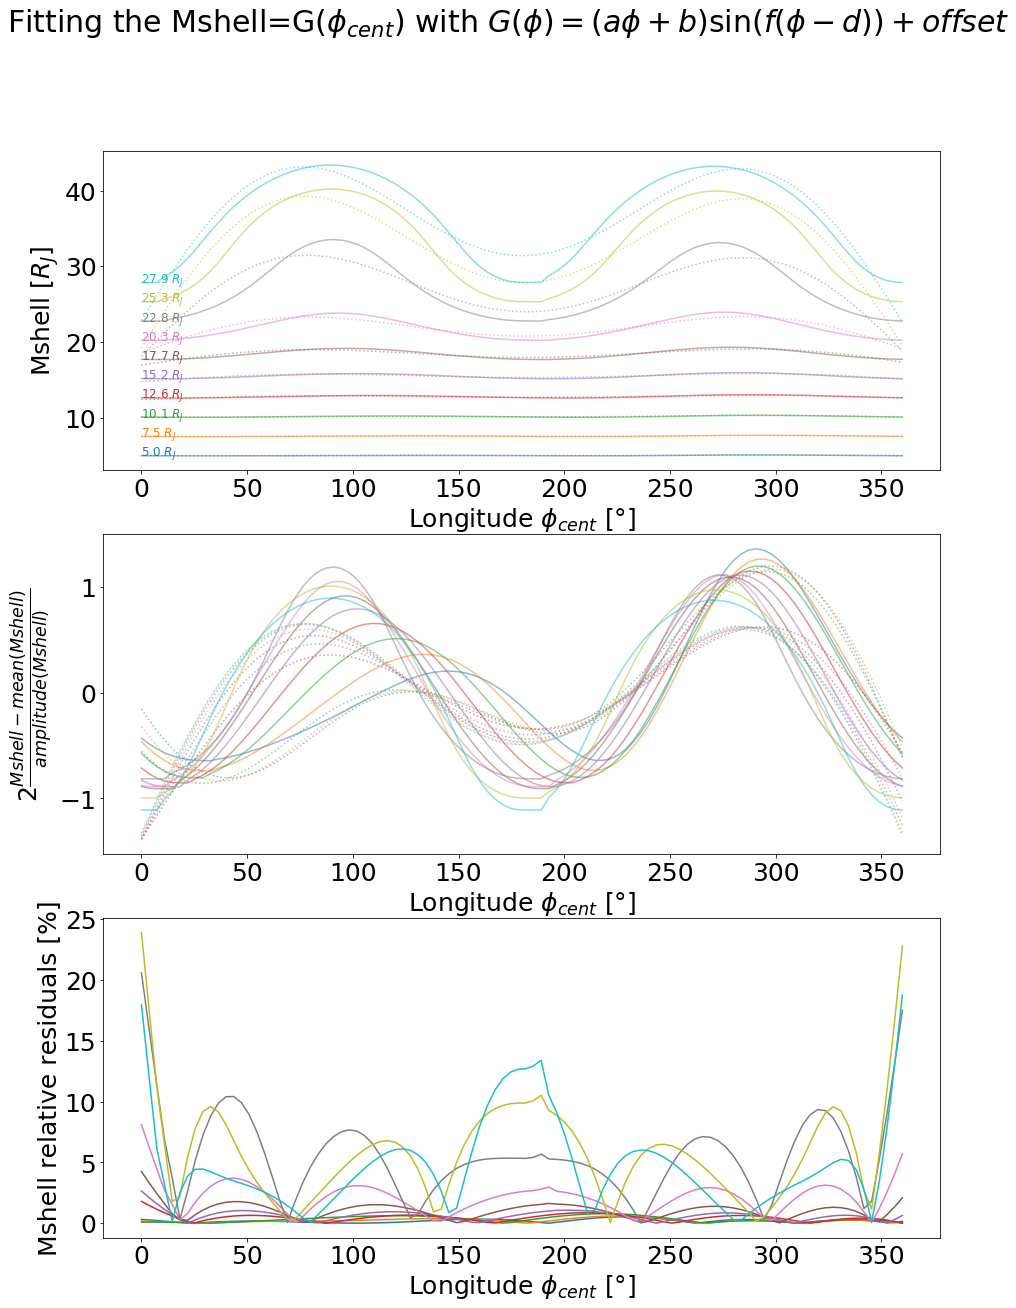

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel(r"2$\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
axs[2].set_ylabel("Mshell relative residuals [%]")
fig.suptitle("Fitting the Mshell=G($\phi_{cent}$) with $G(\phi)=(a\phi + b)\sin(f(\phi-d))+offset$")

def fitfunc_long(longitude, delay, slope, offsetamplitude, offset, frequency):
    return np.sin(frequency*(longitude-delay))*(slope*longitude+offsetamplitude) + offset
             
argsoptlists2 = []
print("Fitting to data : delay, slope, amplitude offset, total offset, frequency")
for k, args0 in zip(range(0, npoints[1], npoints[1]//10), argsoptlists):
    r = radiis[0, k]
    mss = mshells[:, k]
    lons = longitudes[:, k]
    argsopt, _ = fitandplot(axs, fitfunc_long, lons, mss, np.append(args0, [pi/180.]),
                            labelin="{:.1f} $R_J$".format(r),textloc_ind_offset=(0, 0.), 
                            transformfunction=lambda x:2.*(x-np.mean(x))/(np.max(x)-np.min(x)))
    argsoptlists2.append(argsopt)
plt.show()

Even though the suggested model is rather complex, and presents a high number of parameters, the agreement with the data is not satisfying : the modulation is poorly reproduced, in terms of amplitude as well as frequency. Hence, I do not continue down this path, and tackle the problem of finding an analytic approximation for the relation between Mshell and $(r_{cent}, \phi_{cent})$ by starting anew from the study of the Mshell VS $r_{cent}$ profiles.

## Tentative detection of analytical relations between Mshell and the jovicentric distance

The next cell intend to tweak the Mshell VS $r_{cent}$ data in order to extract potential tendances. A first subfigure simply shows the variation of Mshell with radius, at various fixed longitudes.

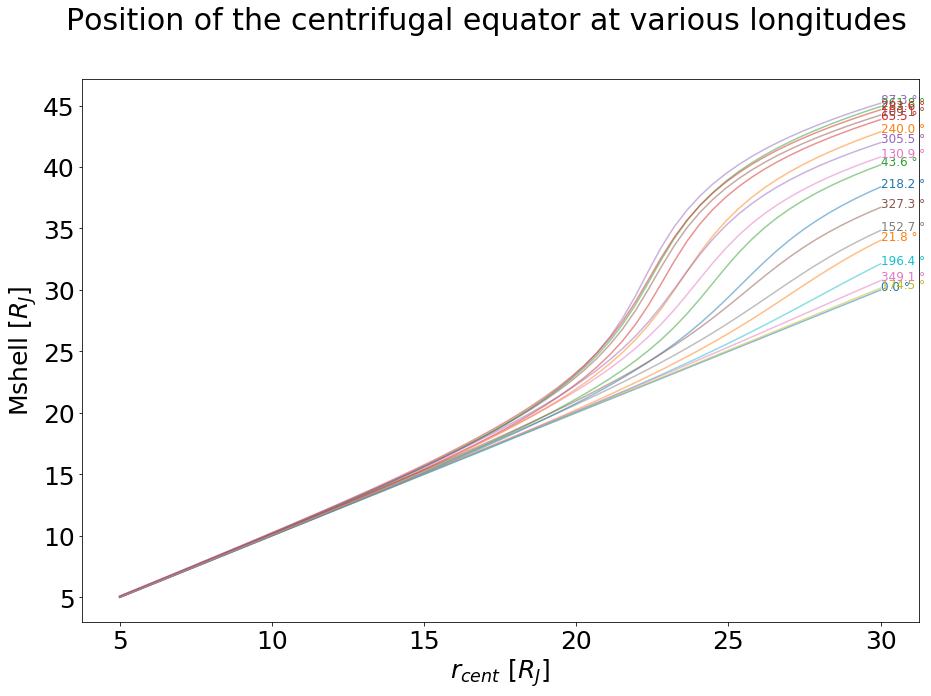

In [9]:
#plot radii
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
# axmodify = fig.add_subplot(212)
for k in range(0, npoints[0], npoints[0]//15):
    lon = longitudes[k, 0]
    mss = mshells[k]
    # mssplot = 2*(mss-np.mean(mss))/(np.max(mss)-np.min(mss))

    p = ax.plot(radiis[k], mss, alpha=0.5)
    ax.text(radiis[k, -1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=labelfontsize)

plt.setp([ax], xlabel="$r_{cent}$ [$R_J$]")
ax.set_ylabel("Mshell [$R_J$]")
axmodify.set_ylabel("2(Mshell - mean(Mshell))/amplitude(Mshell)")
fig.suptitle("Position of the centrifugal equator at various longitudes")
plt.show()

As seen in the figure above, there seems to be a clear affine trend between Mshell and $r_{cent}$. In the
following, we fit an affine function to the first half of rcent range, which seems dominated by this
trend. We then study the remaining dependance.

Fitting to data : slope, offset

 At 0.0 °
Values =  ['1.00', '-0.00']
Variance = ['3.30e-08', '2.46e-06']

 At 36.4 °
Values =  ['1.00', '-0.02']
Variance = ['1.53e-07', '1.14e-05']

 At 72.7 °
Values =  ['1.02', '-0.11']
Variance = ['2.62e-06', '1.96e-04']

 At 109.1 °
Values =  ['1.03', '-0.15']
Variance = ['3.50e-06', '2.61e-04']

 At 145.5 °
Values =  ['1.02', '-0.07']
Variance = ['4.37e-07', '3.26e-05']

 At 181.8 °
Values =  ['1.00', '0.02']
Variance = ['6.92e-08', '5.17e-06']

 At 218.2 °
Values =  ['1.00', '-0.02']
Variance = ['1.52e-07', '1.14e-05']

 At 254.5 °
Values =  ['1.02', '-0.09']
Variance = ['3.03e-06', '2.26e-04']

 At 290.9 °
Values =  ['1.04', '-0.10']
Variance = ['3.71e-06', '2.77e-04']

 At 327.3 °
Values =  ['1.02', '-0.05']
Variance = ['3.31e-07', '2.48e-05']


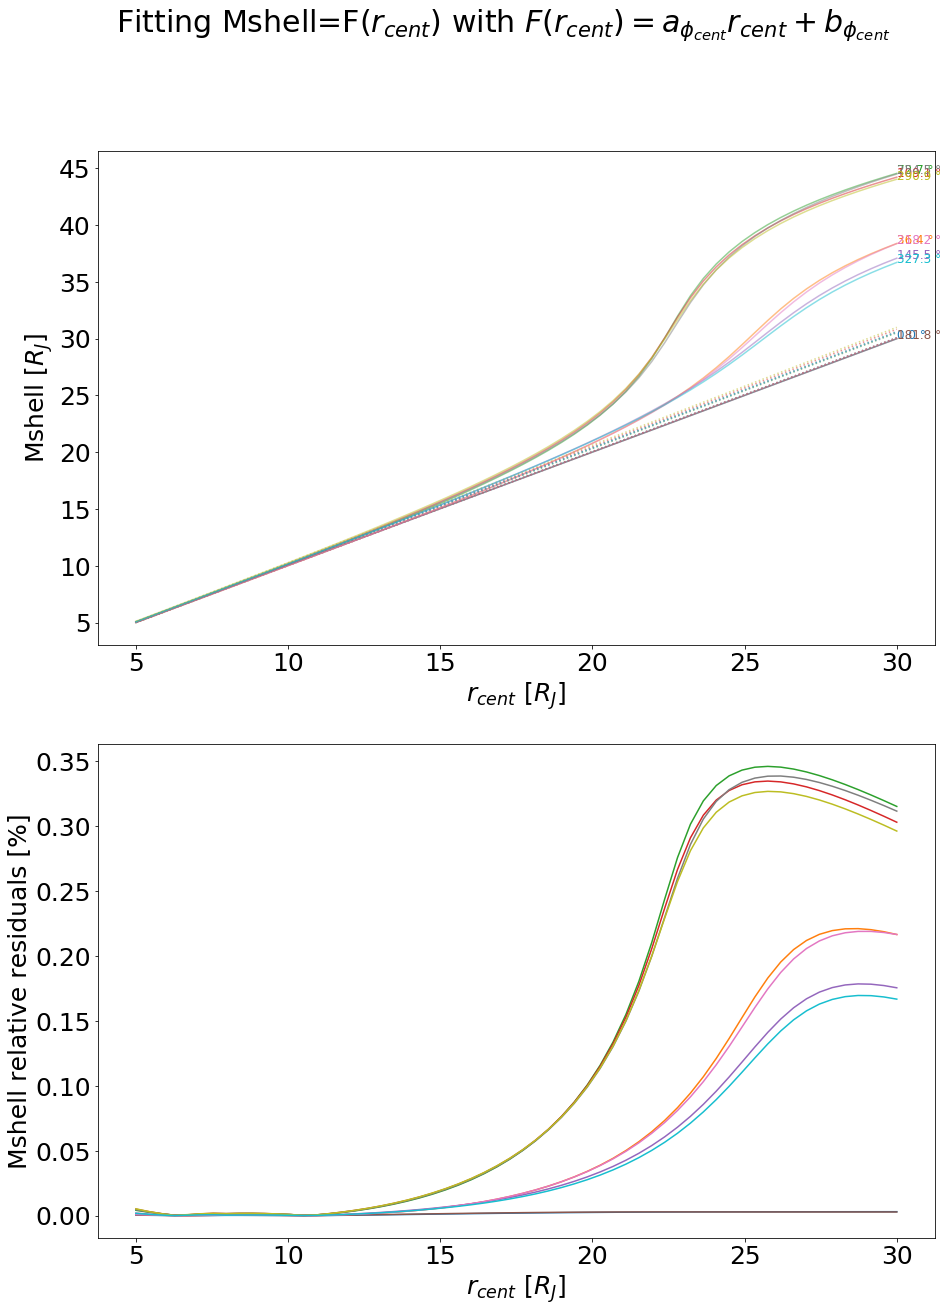

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 20))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel("Mshell relative residuals [%]")
fig.suptitle(r"Fitting Mshell=F($r_{cent}$) with $F(r_{cent}) = a_{\phi_{cent}}r_{cent} + b_{\phi_{cent}}$")

def fitfunc_raffine(r, a, b):
    return a*r + b

argsoptlistraffines = []
print("Fitting to data : slope, offset")
for k in range(0, npoints[0], npoints[0]//10):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    
    fitindices = np.where(rs<12.)[0]
    res = curve_fit(fitfunc_raffine, rs[fitindices], mss[fitindices], p0=np.array([1., 0.1]))
    argsopt = res[0]
    cov = res[1]
    mssmodel = fitfunc_raffine(rs, *argsopt)
    argsoptlistraffines.append(argsopt)
    
    print("\n At {:.1f} °".format(lon))
    print("Values = ", ["{:.2f}".format(arg) for arg in argsopt])
    print("Variance =", ["{:.2e}".format(cov[i, i]) for i in range(argsopt.size)])
    
    p = axs[0].plot(rs, mss, alpha=0.5)
    axs[0].plot(rs, mssmodel, alpha=0.5, color=p[0].get_color(), linestyle=":")
    axs[0].text(rs[-1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=labelfontsize)
    axs[1].plot(rs, np.abs(mss-mssmodel)/mss, color=p[0].get_color())
    
plt.show()

We fit the residuals with a hyperbolic tangent function, building on *Phipps et Bagenal (2021)*. The results of this second fit are shown bellow.

Fitting to data : amplitude, spatial rate, spatial delay, offset

 At 0.0 °
Values =  ['-0.05', '0.14', '19.17', '-0.04']
Variance = ['1.11e-06', '3.62e-05', '2.09e-02', '3.81e-07']

 At 36.4 °
Values =  ['4.46', '0.29', '24.83', '4.53']
Variance = ['2.81e-03', '5.66e-05', '3.47e-03', '2.33e-03']

 At 72.7 °
Values =  ['7.16', '0.40', '22.25', '7.33']
Variance = ['2.70e-03', '1.26e-04', '1.57e-03', '2.23e-03']

 At 109.1 °
Values =  ['6.86', '0.40', '22.21', '7.03']
Variance = ['2.75e-03', '1.30e-04', '1.77e-03', '2.26e-03']

 At 145.5 °
Values =  ['3.61', '0.26', '25.05', '3.65']
Variance = ['2.42e-03', '4.20e-05', '4.99e-03', '2.01e-03']

 At 181.8 °
Values =  ['-0.04', '0.16', '17.57', '-0.04']
Variance = ['8.86e-07', '6.50e-05', '2.21e-02', '3.41e-07']

 At 218.2 °
Values =  ['4.53', '0.28', '25.07', '4.59']
Variance = ['3.01e-03', '4.15e-05', '3.70e-03', '2.51e-03']

 At 254.5 °
Values =  ['7.07', '0.38', '22.38', '7.22']
Variance = ['2.66e-03', '1.00e-04', '1.61e-03', '2.16e-03']

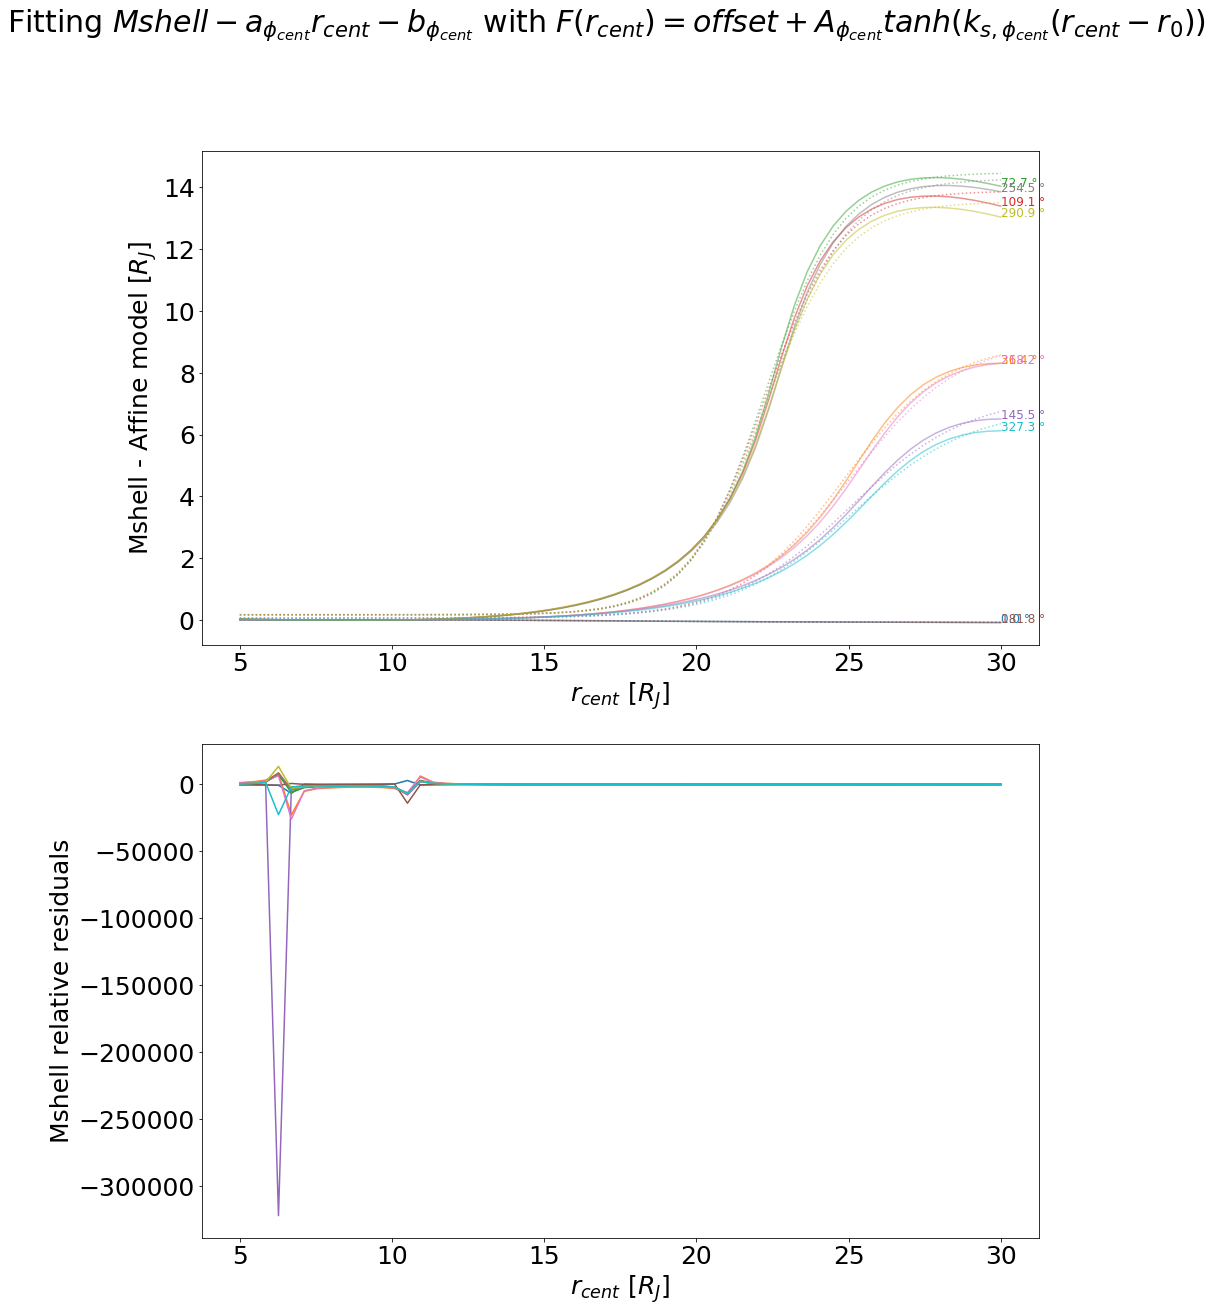

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15, 20))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell - Affine model [$R_J$]")
axs[1].set_ylabel("Mshell relative residuals")
fig.suptitle(r"Fitting $Mshell - a_{\phi_{cent}} r_{cent} - b_{\phi_{cent}}$ "\
             "with $F(r_{cent}) = offset + A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_0))$")

def fitfunc_rrest(r, amplitude, kspat, rdelay, offset):
    return offset + amplitude * np.tanh(kspat*(r-rdelay))

argsoptlistrests = []
print("Fitting to data : amplitude, spatial rate, spatial delay, offset")
for k, args0affine in zip(range(0, npoints[0], npoints[0]//10),argsoptlistraffines):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k] - fitfunc_raffine(rs, *args0affine)
    argsopt, _ = fitandplot(axs, fitfunc_rrest, rs, mss, np.array([1., 0.5, 12., np.mean(mss)]),
                            labelin="{:.1f} °".format(lon),textloc_ind_offset=(-1, 0.),
                            transformfunction=None)
    argsoptlistrests.append(argsopt)
plt.show()

The two-step fitting, meaning, a first fit of the Mshell VS $r_{cent}$ relation with an affine function, followed by a fit of the consequent residuals with a hyperbolic tangent provides a rather close agreement and low residuals. We use the best fitted parameters resutling from this derivation to feed a new optimisation, which directly fits the total function (affine in addition to $tanh$ variations) to the data. The final results of this approach are show bellow.

Fitting to data : slope, offset, amplitude, spatial rate, spatial delay

At 0.0 °: direct fitting failed
Values (2-steps fit) :  1.00 -0.04 -0.05 0.14 19.17

 At 36.4 °
Values =  ['1.03', '3.85', '4.11', '0.33', '24.85']
Variance = ['1.74e-05', '1.10e-02', '3.92e-03', '7.90e-05', '1.82e-03']

 At 72.7 °
Values =  ['1.08', '5.97', '6.58', '0.46', '22.32']
Variance = ['8.42e-05', '3.64e-02', '8.30e-03', '1.88e-04', '9.87e-04']

 At 109.1 °
Values =  ['1.09', '5.64', '6.29', '0.45', '22.29']
Variance = ['8.95e-05', '3.86e-02', '8.88e-03', '2.06e-04', '1.15e-03']

 At 145.5 °
Values =  ['1.04', '3.04', '3.29', '0.29', '25.05']
Variance = ['1.13e-05', '7.98e-03', '3.22e-03', '6.41e-05', '2.52e-03']

 At 181.8 °
Values =  ['1.00', '-0.07', '-0.08', '0.11', '17.73']
Variance = ['6.31e-06', '1.98e-03', '1.80e-03', '7.87e-04', '1.90e-02']

 At 218.2 °
Values =  ['1.03', '3.95', '4.19', '0.31', '25.07']
Variance = ['1.48e-05', '1.03e-02', '4.03e-03', '5.90e-05', '1.92e-03']

 At 254.5 °
Values =

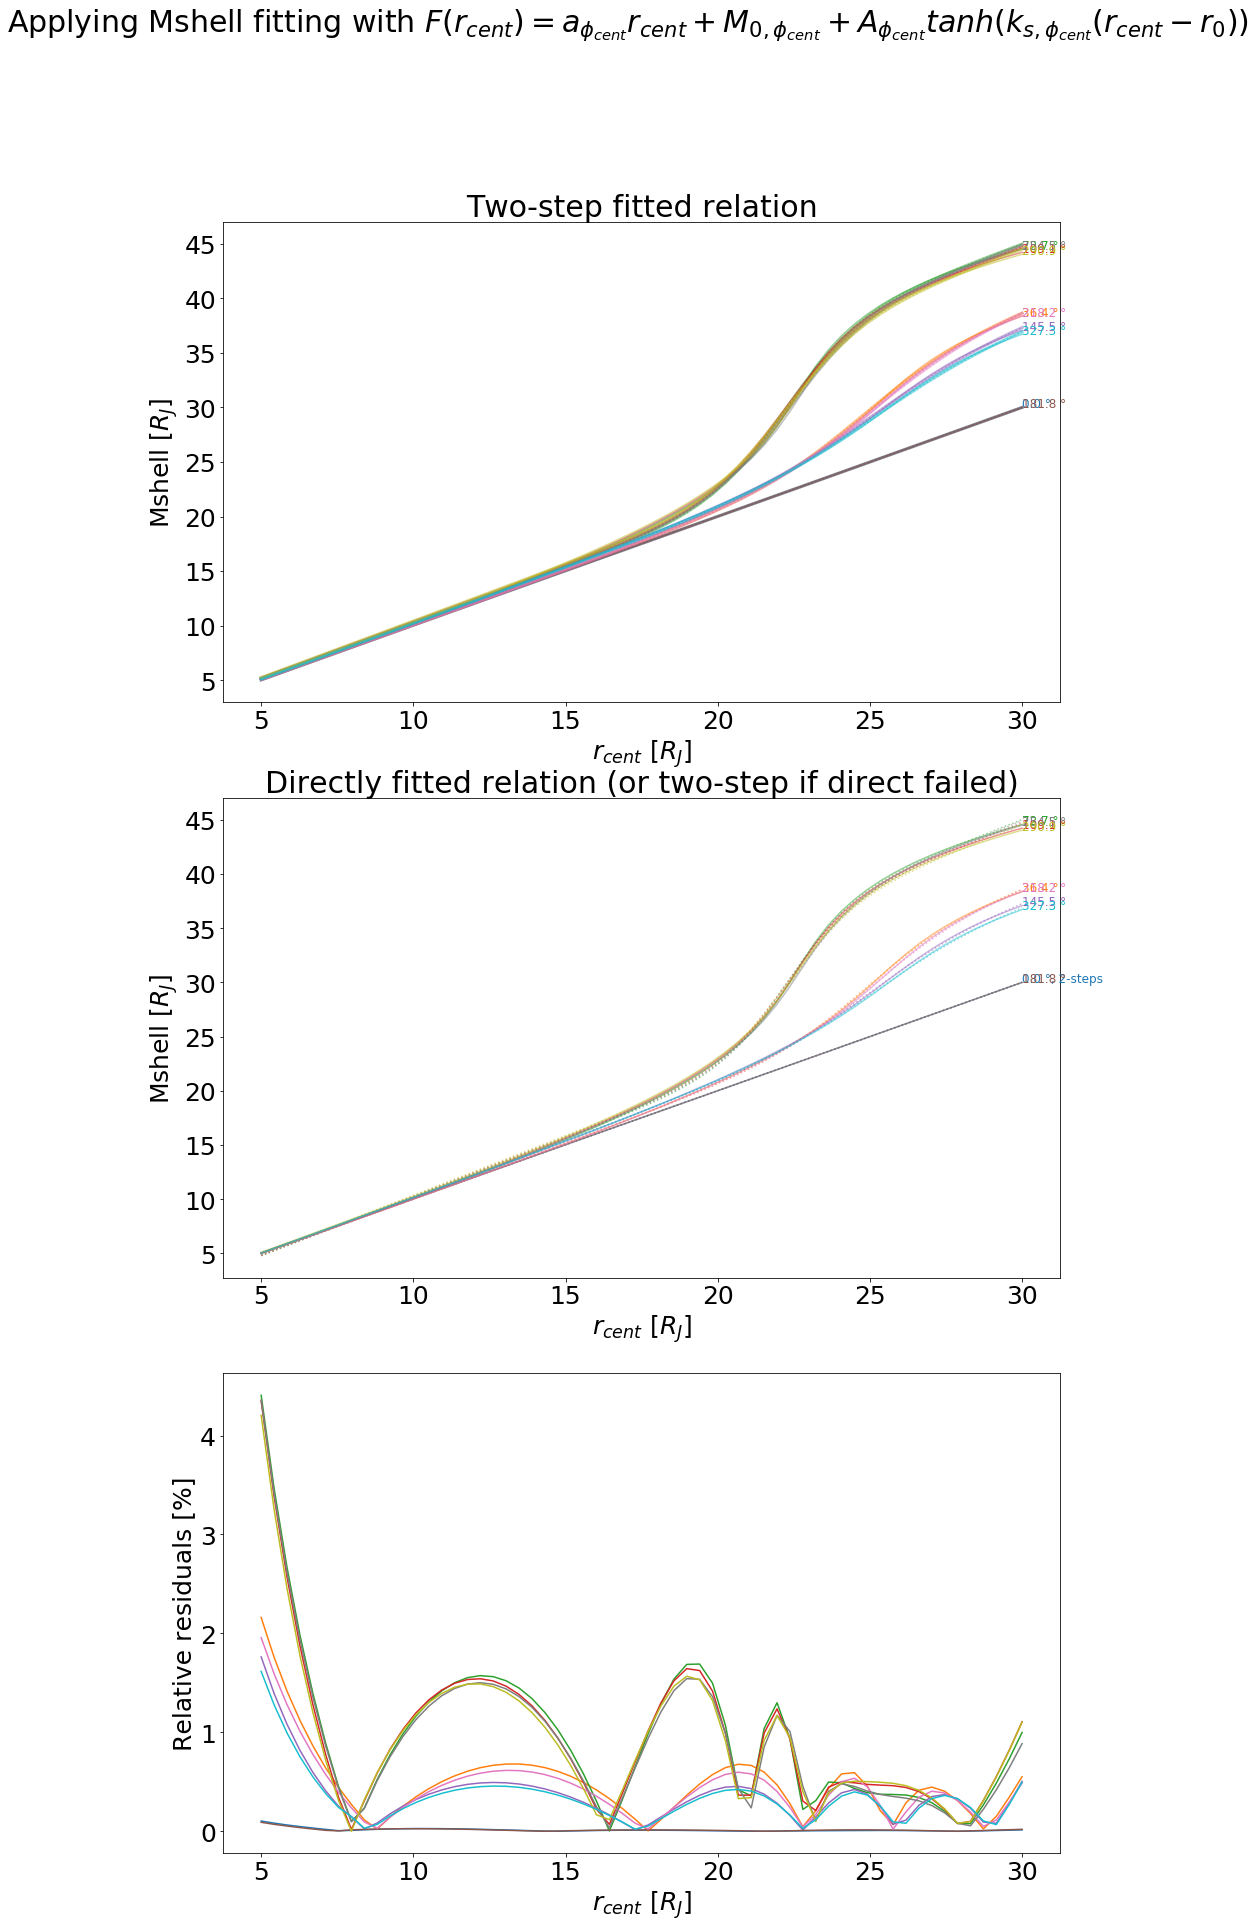

In [12]:
# Plotting the total model Mshell = F(r_cent) and intending a total fit
fig, axs = plt.subplots(3, 1, figsize=(15, 30))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[0].set_title("Two-step fitted relation")
axs[1].set_ylabel("Mshell [$R_J$]")
axs[1].set_title("Directly fitted relation (or two-step if direct failed)")
axs[2].set_ylabel("Relative residuals [%]")
fig.suptitle(r"Applying Mshell fitting with $F(r_{cent}) = a_{\phi_{cent}} r_{cent} + M_{0,\phi_{cent}} "\
             "+ A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_0))$")

def fitfunc_rglobal(r, a, M0, amplitude, kspat, rdelay):
    return a*r + M0 + amplitude * np.tanh(kspat*(r-rdelay))

print("Fitting to data : slope, offset, amplitude, spatial rate, spatial delay")
for k, args0affine, args0rests in zip(range(0, npoints[0], npoints[0]//10),argsoptlistraffines, argsoptlistrests):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    mssmodel0 = fitfunc_raffine(rs, *args0affine) + fitfunc_rrest(rs, *args0rests)
    
    p = axs[0].plot(rs, mss, alpha=0.5)
    axs[0].plot(rs, mssmodel0, alpha=0.5, color=p[0].get_color(), linestyle=":")
    axs[0].text(rs[-1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=labelfontsize)
    args0 = np.append(np.array([args0affine[0], args0affine[-1]+args0rests[-1]]), args0rests[:-1])
    axs[0].plot(rs, fitfunc_rglobal(rs, *args0), color=p[0].get_color(), linewidth=3, alpha=0.5)

    try:
        argsopt, _ = fitandplot(axs[1:], fitfunc_rglobal, rs, mss, args0, 
                                    labelin="{:.1f} °".format(lon), textloc_ind_offset=(-1, 0.), 
                                    transformfunction=None, colorin=p[0].get_color())
    except RuntimeError:
        print("")
        print("At {:.1f} °: direct fitting failed".format(lon))
        print("Values (2-steps fit) : ", *["{:.2f}".format(arg) for arg in args0])
        
        axs[1].plot(rs, mss, alpha=0.5, color=p[0].get_color())
        axs[1].plot(rs, mssmodel0, alpha=0.5, color=p[0].get_color(), linestyle=":")
        axs[1].text(rs[-1], mss[-1], "{:.1f} °, 2-steps".format(lon), color=p[0].get_color(), fontsize=labelfontsize)        
        axs[2].plot(rs, 100.*np.abs(mss-mssmodel0)/mss, color=p[0].get_color())
plt.show()

The latest fitting attempt statisfyingly reproduce the relation between rcent and Mshell at all
longitudes. In the following, we apply the same protocol to all longitude samples : 
1. fit an affine function to the Mshell VS $r_{cent}$ profiles, and retrieve the residuals (Mshell - model)
2. fit a tanh function to the residuals
3. use the best optimised parameters computed in step 1 and 2 to feed a direct fit of an affine+tanh function to the Mshell VS $r_{cent}$ profiles

In [13]:
# Compute fitted parameters of the Mshell = F(r) law at each longitude
args0rlists = []
argsoptlists = []

for k in range(0, npoints[0]):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    
    # pre-fit analysis : compute reasonable parameters to start the global fit
    fitindices = np.where(rs<12.)[0]
    resaffine, _ = curve_fit(fitfunc_raffine, rs[fitindices], mss[fitindices], p0=np.array([1., 0.1]))
    mssrests = mss - fitfunc_raffine(rs, *resaffine)
    resrest, _ = curve_fit(fitfunc_rrest, rs, mssrests, p0=np.array([1., 0.5, 22., np.mean(mss)]))
    args0 = np.append(np.array([resaffine[0], resaffine[-1]+resrest[-1]]), resrest[:-1])
    args0rlists.append(args0[:])
    
    # global fit, starting from the results of the pre-fit analysis
    try : 
        argsoptr, _ = curve_fit(fitfunc_rglobal, rs, mss, p0=args0)
        argsoptlists.append(argsoptr)
    except RuntimeError: 
        print("At lon = {:.1f}°, global fitting failed : using the 2-step fit parameters".format(lon))
        argsoptlists.append(args0[:])
        
args0rlists = np.array(args0rlists)
argsoptlists = np.array(argsoptlists)
num_args= args0rlists[0].size

At lon = 0.0°, global fitting failed : using the 2-step fit parameters
At lon = 3.6°, global fitting failed : using the 2-step fit parameters
At lon = 7.3°, global fitting failed : using the 2-step fit parameters
At lon = 178.2°, global fitting failed : using the 2-step fit parameters
At lon = 360.0°, global fitting failed : using the 2-step fit parameters


Having derived the best fitting parameters for the chosen Mshell - $r_{cent}$ relation, I then study their variations with longitude. The aim of this is to find analytical approximation for the dependance of each parameter on longitude. This will finally provide a global function to account for the dependance of Mshell on both $r_{cent}$ and $\phi_{cent}$.

Fitting to data : slope, offset, amplitude, spatial rate, spatial delay

 Parameter a
Values =  0.02 89.85 64.26 1.02
Variance = 2.28e-08 5.00e-02 1.63e-01 1.26e-08

 Parameter M_0 [R_J]
Values =  3.57 91.75 40.04 4.36
Variance = 6.73e-03 4.09e-01 1.35e+00 3.89e-03

 Parameter A [R_J]
Values =  3.88 91.83 131.80 -4.13
Variance = 1.68e-02 8.68e-01 1.13e+00 9.71e-03

 Parameter k_s [R_J^{-1}]
Values =  0.29 93.98 131.69 -0.20
Variance = 3.94e-04 3.65e+00 4.74e+00 2.22e-04

 Parameter r_0 [R_J]
Values =  653.93 14311.20 7287.94 677.25
Variance = 2.43e+14 2.92e+16 7.29e+15 2.43e+14


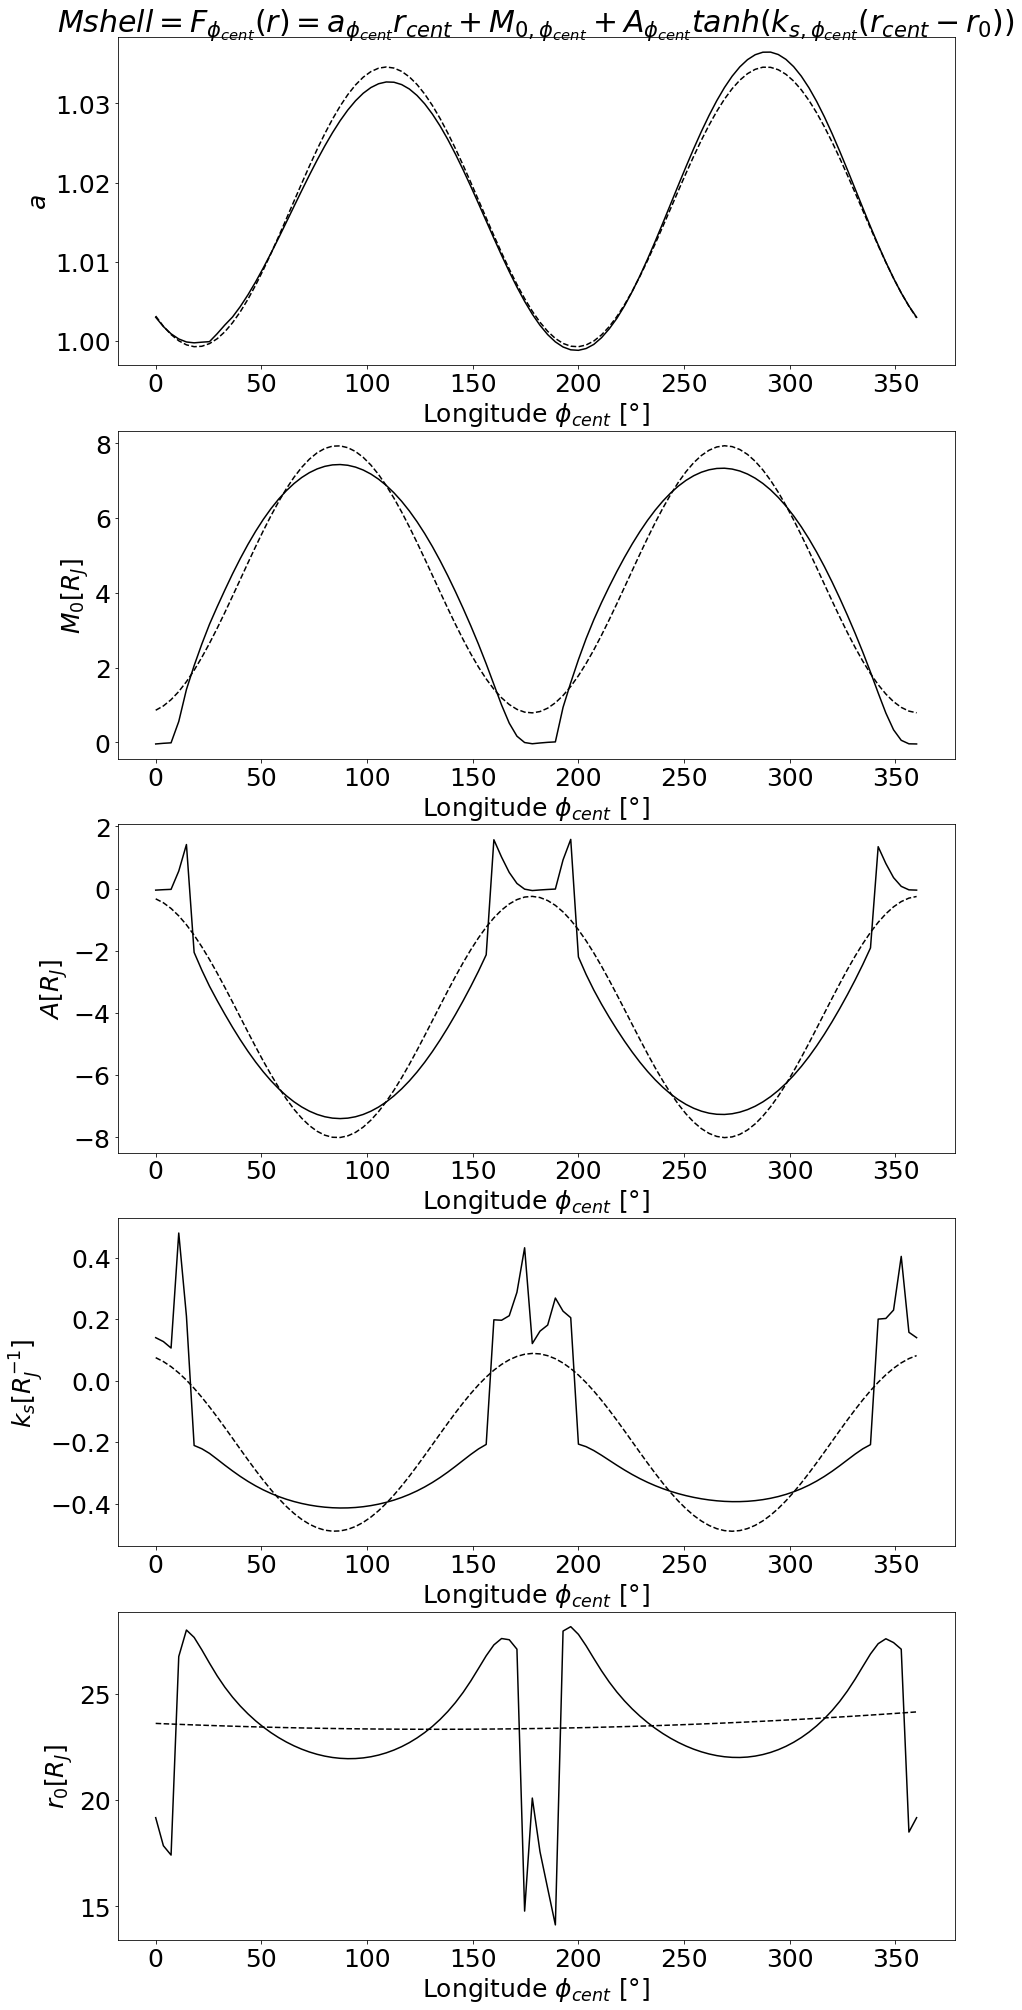

In [14]:
# Plot and fit the evolution of the parameters of the Mshell = F(r) law with latitude
fig, axs = plt.subplots(num_args, 1, figsize=(15, 7*num_args))
axs[0].set_title(r"$Mshell = F_{\phi_{cent}}(r) = a_{\phi_{cent}} r_{cent} + M_{0,\phi_{cent}} + A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_0))$")
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")

def fitfunc_paramsgeneral(lons, amplitude, period, delay, offset):
    return amplitude*np.sin(pi*(lons-delay)/period)+offset

lons = longitudes[:, 0]
initparam = [[0.01, 150., 50., 1.02], 
             [3.5, 150., 25., 3.5], 
             [4, 180., 150., -3],
             [0.4, 150., 150., 0.],
             [2.5, 150., 125., 25.]]
             

print("Fitting to data : slope, offset, amplitude, spatial rate, spatial delay")
for k, (argsopt, label, iparam) in enumerate(zip(np.transpose(args0rlists),
                                                 ["a", "M_0 [R_J]", "A [R_J]", "k_s [R_J^{-1}]", "r_0 [R_J]"], initparam)):
    
    axs[k].plot(lons, argsopt, color="black")
    axs[k].set_ylabel("${}$".format(label))
    
    print("\n Parameter {}".format(label))
    try:
        bestlaw, cov = curve_fit(fitfunc_paramsgeneral, lons, argsopt, p0=np.array(iparam))
        
        print("Values = ", *["{:.2f}".format(arg) for arg in bestlaw])
        print("Variance =", *["{:.2e}".format(cov[i, i]) for i in range(bestlaw.size)])
        axs[k].plot(lons, fitfunc_paramsgeneral(lons, *bestlaw), color="black", linestyle="--")
    except RuntimeError:
        print("Fitting failed")
plt.show()

The dependency of all parameters on the longitude presents a period of 180 ° approximately. They are fitted with sine functions. Although a, M0 and, to a certain extent, A are rather well approximated by sinusoïdal variations, the remaining parameters $k_s$ and $r_0$ show a much more complex behaviour with longitude.

# Conclusion
Based on the work of *Phipps et Bagenal (2021)* and the script of Jonas Rabia for Mshell computation, I successfully derived an approximate analytical expression for the dependance of Mshell on $r_{cent}$ at each longitude:
$Mshell = F_{\phi_{cent}}(r_{cent})$ with 
$$F_{\phi_{cent}}(r) = a_{\phi_{cent}} r_{cent} + M_{0,\phi_{cent}} + A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_{0,\phi_{cent}}))$$

From there, the writing of a global analytical description of the Mshell value associated to the location of each centrifugal equator requires to fit an analytical model to the variation of each parameter with longitude. I succeded to do this using a sine function $H(\phi_{cent}) = A_1 sin(\frac{\pi (\phi_{cent} - \phi_{cent, 0}}{P}))+p_0$ for $a_{\phi_{cent}}$, $M_{0,\phi_{cent}}$ and, to a certain extent, $A_{\phi_{cent}}$. However, the remaining parameters, $k_{s,\phi_{cent}}$ and $r_{0,\phi_{cent}}$ cannot be approximated by such a simple function.

